In [149]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
import json
from jax.tree_util import Partial


from dataclasses import dataclass
import warnings
from typing import List, Union, Optional

import cola

import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Array,
    Float,
    install_import_hook,
    Num,
)
import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.typing import (
    Array,
    ScalarInt,
    ScalarFloat,
)
from gpjax.distributions import GaussianDistribution

import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]



import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
key = jr.PRNGKey(123)

import scipy.optimize as spo
from dataclasses import dataclass
from gpjax.base import param_field, static_field
from gpjax.objectives import AbstractObjective
import math
from gpjax.kernels.base import AbstractKernel
from gpjax.kernels import RBF
from gpjax.objectives import AbstractObjective
import optax as ox
from gpjax.kernels.stationary.utils import squared_distance
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from jaxtyping import (
    Float,
    Num,
)
from simple_pytree import Pytree
from optax import GradientTransformation
import jax.tree_util as jtu





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

def optim_builder(optim_pytree):

    def _init_leaf(o, p):
        if isinstance(o, GradientTransformation):
            return o.init(p)
        else:
            return None

    def _update_leaf(o, u, s, p):
        if isinstance(o, GradientTransformation):
            return tuple(o.update(u, s, p))
        else:
            return jtu.tree_map(jnp.zeros_like, p)

    def _get_updates(o, u, p):
        if isinstance(o, GradientTransformation):
            return u[0]
        else:
            return u
    
    def _get_state(o, u):
        if isinstance(o, GradientTransformation):
            return u[1]
        else:
            return None

    def init_fn(params):
        return jtu.tree_map(_init_leaf, optim_pytree, params, is_leaf=lambda x: isinstance(x, GradientTransformation))

    def update_fn(updates, state, params):
        updates_state = jtu.tree_map(_update_leaf, optim_pytree, updates, state, params, is_leaf=lambda x: isinstance(x, GradientTransformation))
        updates = jtu.tree_map(_get_updates, optim_pytree, updates_state, params, is_leaf=lambda x: isinstance(x, GradientTransformation))
        state = jtu.tree_map(_get_state, optim_pytree, updates_state, is_leaf=lambda x: isinstance(x, GradientTransformation))

        return updates, state

    return GradientTransformation(init_fn, update_fn)


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [170]:
# load data
X2d = jnp.array(jnp.load("..//data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# random shuffle
X2d = jr.permutation(key, X2d)
X3d = jr.permutation(key, X3d)
Xstatic = jr.permutation(key, Xstatic)
Y = jr.permutation(key, Y)

# look at ERA5 rain
Y = Y[:,0:1]  

# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["RH", "tehta_e+", "theta_e", "theta_e*"]
idx_3d = [1, 9, 7, 8 ]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2]))
Xstatic = Xstatic.at[:,2].set(sigma_o)
# idx_static = [2]
# Xstatic = Xstatic[:,idx_static]


# no 2d for now
# idx_2d = []
# X2d = X2d[:,idx_2d]


#remove all pressure levels below 500 hPA
lowest_idx = 11 # 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]

# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]


# also log Y
print(f"Applied log transform to Y")
Y = jnp.log(Y+1e-12)
print(f"then standardized Y")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std

# standardize inputs
X3d_std = jnp.std(X3d, axis=0)
X3d_mean = jnp.mean(X3d,axis=0)
X3d = (X3d - X3d_mean) / X3d_std
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std
Xstatic_std = jnp.std(Xstatic, axis=0)
Xstatic_mean = jnp.mean(Xstatic,axis=0)
Xstatic = (Xstatic - Xstatic_mean) / Xstatic_std


# look at all data but 1_000 test

N_test = 100
N_train = len(X2d) - N_test 
print(f"Using {N_train} training and {N_test} testing points!")
num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")


Removed 24779 entries with nan
Removed all pressure levels below [50000.] hPa
Applied log transform to Y
then standardized Y
Using 75121 training and 100 testing points!
using 5 static variables
using 5 2d variables
using 4 3d variables


In [219]:
@dataclass
class VerticalSmoother(gpx.base.Module):
    smoother_mean: Float[Array, "1 D"]  = param_field(None)
    smoother_input_scale: Float[Array, "1 D"] = param_field(None, bijector=tfb.Softplus(low=jnp.array(1.0e-5, dtype=jnp.float64)))
    Z_levels: Float[Array, "1 L"] = static_field(pressure_levels)

    def __post_init__(self):
        self.Z_mean = jnp.mean(self.Z_levels)
        self.Z_std = jnp.std(self.Z_levels)
        self.Z_levels = (self.Z_levels - self.Z_mean) / self.Z_std

    def smooth(self) -> Num[Array, "D L"]:
        smoothing_weights = jnp.exp(-0.5*((self.Z_levels-self.smoother_mean.T)/(self.smoother_input_scale.T))**2) # [D, L]
        return  (smoothing_weights/ jnp.sum(smoothing_weights, axis=-1, keepdims=True)) # [D, L]
    
    def smooth_data(self, dataset: VerticalDataset) -> Num[Array, "N D"]:
        x3d, x2d, xstatic, y = dataset.X3d, dataset.X2d, dataset.Xstatic, dataset.y
        x3d_smooth = jnp.sum(jnp.multiply(self.smooth() , x3d), axis=-1) # [N, D_3d]
        x = jnp.hstack([x3d_smooth, x2d, xstatic]) # [N, D_3d + D_2d +D_static]
        return x, y



@dataclass
class VerticalDataset(Pytree):
    X2d: Num[Array, "N D"] = None
    X3d: Num[Array, "N D L"] = None
    Xstatic: Num[Array, "N D"] = None
    y: Num[Array, "N 1"] = None

    def __post_init__(self) -> None:
        gpx.dataset._check_precision(self.X2d, self.y)
        gpx.dataset._check_precision(self.Xstatic, self.y)
        gpx.dataset._check_precision(self.X3d, self.y)
        
    @property
    def X(self):
        return NotImplementedError("Use X2d, X3d or Xstatic instead")


@dataclass
class CustomConjugatePosterior(gpx.gps.ConjugatePosterior):
    smoother: VerticalSmoother = VerticalSmoother()
    
    def predict(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: Dataset,
        kernel_between_train: Optional[AbstractKernel] = None,
        kernel_with_test: Optional[AbstractKernel] = None,
    ) -> GaussianDistribution:

        # smooth data to get in form for preds
        x,y = posterior.smoother.smooth_data(train_data)
        smoothed_train_data = gpx.Dataset(x, y)
        return super().predict(test_inputs, smoothed_train_data, kernel_between_train, kernel_with_test)


class CustomAdditiveConjugatePosterior(CustomConjugatePosterior):
    def __post__init__(self):
        assert isinstance(self.prior.kernel, AdditiveKernel), "AdditiveConjugatePosterior requires an AdditiveKernel"

    def predict_additive_component(
        self,
        test_inputs: Num[Array, "N D"],
        train_data: gpx.Dataset,
        component_list: List[List[int]]
    ) -> GaussianDistribution:
        r"""Get the posterior predictive distribution for a specific additive component."""
        specific_kernel = self.prior.kernel.get_specific_kernel(component_list)
        return self.predict(test_inputs, train_data, kernel_with_test = specific_kernel)

    def get_sobol_index(self, train_data: gpx.Dataset, component_list: List[int]) -> ScalarFloat:
        """ Return the sobol index for the additive component corresponding to component_list. """
        x,y = posterior.smoother.smooth_data(train_data)
        component_posterior = self.predict_additive_component(x, train_data, component_list)
        full_posterior= self.predict(x, train_data) # wasteful as only need means
        return jnp.var(component_posterior.mean()) / jnp.var(full_posterior.mean())



class CustomConjugateMLL(gpx.objectives.ConjugateMLL):
    def step(
        self,
        posterior: CustomConjugatePosterior,
        train_data: VerticalDataset,
    ) -> ScalarFloat:
        x,y = posterior.smoother.smooth_data(train_data)
        return super().step(posterior, gpx.Dataset(x, y))



def plot_params(model, title=""):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    if isinstance(model.prior.kernel, gpx.kernels.AdditiveKernel):
        lengthscales = jnp.array([model.prior.kernel.kernels[i].lengthscale[0] for i in range(num_variables)])
    else:
        lengthscales = model.prior.kernel.lengthscale
    smoothing_weights = model.smoother.smooth() # [4, 21]
    for i in range(num_3d_variables):
        plt.plot(smoothing_weights[i,:].T,pressure_levels[0,:], label=f"{names_3d[i]} with lengthscales_ {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f" other lengthscales are {lengthscales[num_3d_variables:]}")
    plt.gca().invert_yaxis()



  0%|          | 0/150 [00:00<?, ?it/s]

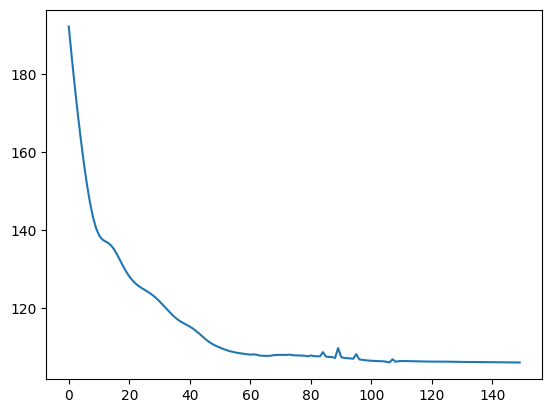

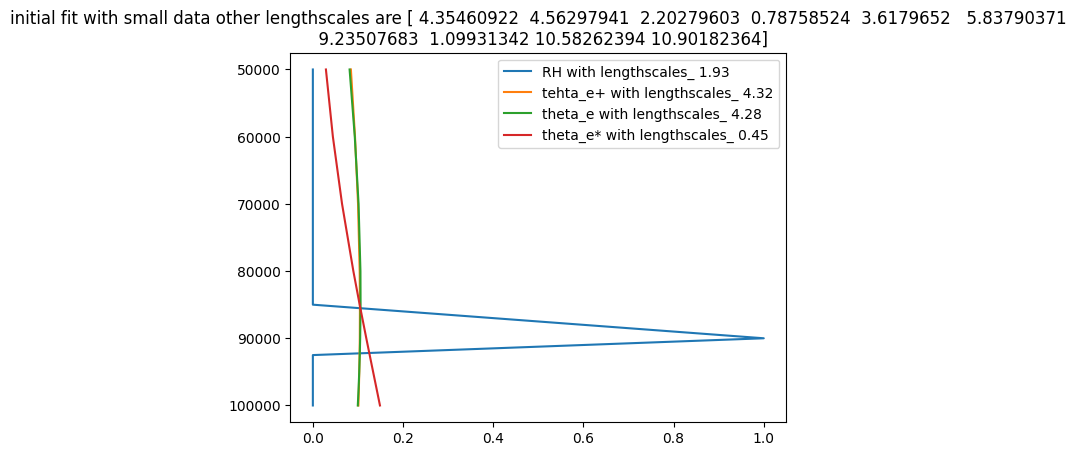

In [220]:
@dataclass
class RBF(RBF):
    dummy: AbstractKernel = gpx.kernels.RBF()

# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=100
D_small = VerticalDataset(
    X2d = X2d[:num_data_for_init,:],
    X3d = X3d[:num_data_for_init,:,:],
    Xstatic = Xstatic[:num_data_for_init,:],
    y=Y[:num_data_for_init,:],
)

lengthscale_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
smoother = VerticalSmoother(jnp.array([[0.0]*num_3d_variables]), jnp.array([[1.0]*num_3d_variables]))

# kernel = RBF(variance = jnp.var(Y), lengthscale=jnp.array([1.0]*num_variables)).replace_bijector(lengthscale=lengthscale_bij)
base_kernels= [RBF(lengthscale=jnp.array([1.10]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij).replace_trainable(variance=False) for i in range(num_variables)]
max_interaction = 2
kernel = gpx.kernels.AdditiveKernel(kernels=base_kernels,interaction_variances=jnp.array([1.0]*(max_interaction + 1)) * jnp.var(D_small.y), max_interaction_depth=max_interaction)


prior = gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=num_data_for_init)
# posterior = CustomConjugatePosterior(prior=prior, likelihood=likelihood, smoother=smoother)
posterior = CustomAdditiveConjugatePosterior(prior=prior, likelihood=likelihood, smoother=smoother)
objective = jax.jit(CustomConjugateMLL(negative=True))
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=objective,
    train_data=D_small,
    optim=ox.adamw(learning_rate=1e-1),
    num_iters=150,
    key=jr.PRNGKey(42),
    safe=False,
)
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")



# # choose inducing inputs and init SVGP
# num_inducing = 100
# z = jr.normal(key, (num_inducing , D.X.shape[-1])) # allow this

# init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# # todo try whitening ?
# q = gpx.variational_families.VariationalGaussian(
#     posterior=opt_posterior, 
#     inducing_inputs=z,
#     variational_mean= init_posterior_at_inducing.mean()[:,None],
#     variational_root_covariance= jnp.linalg.cholesky(init_posterior_at_inducing.covariance() + 1e-5 * jnp.eye(num_inducing)), # todo check this is right!
# )

# #q = q.replace_trainable(inducing_inputs=False)
# # q = q.replace_trainable(variational_mean=False)
# # q = q.replace_trainable(variational_root_covariance=False)

# objective = jax.jit(gpx.objectives.ELBO(negative=True))


# def zero_grads():
#     def init_fn(_): 
#         return ()
#     def update_fn(updates, state, params=None):
#         return jax.tree_map(jnp.zeros_like, updates), ()
#     return ox.GradientTransformation(init_fn, update_fn)

# optim_pytree = q.replace(
#     posterior = zero_grads(), 
#     variational_mean = ox.adamw(1e-2),
#     variational_root_covariance = ox.adamw(1e-2), 
#     inducing_inputs= ox.adamw(1e-2),
#     )





# optim = optim_builder(optim_pytree)

# opt_q, history = gpx.fit(
#     model=q,
#     objective=objective,
#     train_data=D,
#     optim=optim,
#     num_iters=500,
#     key=jr.PRNGKey(42),
#     batch_size=512,
# )

# plt.figure()
# plt.plot(history)
# plot_params(opt_q,D,  title="full fit")


In [232]:
scores = []
for i in range(num_variables):
    for j in range(i,num_variables):
        scores.append(opt_posterior.get_sobol_index(D_small, [i,j]))
scores = jnp.array(scores)

AttributeError: 'ArrayImpl' object has no attribute 'numpy'